# Differential abundance

Neither alpha or beta diversity analysis tells us which taxa are different in our treatment groups. For this, we use differential abundance (DA) analysis. DA methods compare the abundance of each taxa between our treatment groups to tell which are differentially abundant.

There are many different tools for conducting DA analysis, and no gold standard. The problem is that there are many statistical challenges with analysing amplicon data, which the different tools try to solve in different ways:
* Compositionality: The abundances of taxa are not indepedent of each other (see also the [Compositionality](https://microucph.github.io/amplicon_data_analysis/html/compositionality.html) notebook)
* Zero-inflation: There are many zeroes; that is, most taxa are absent in most samples
* Skewed distributions: Few taxa are abundant, and most taxa are rare
* Counts: Abundances are represented by counts of reads, which changes the statistical assumptions
* Multiple hypothesis problem: Conducting many statistical tests require corrections (See [Multiple correction](https://microucph.github.io/amplicon_data_analysis/html/multi.html) notebook)

### Example dataset and DAtest package

In [1]:
# Load phyloseq object and phyloseq package
library(phyloseq)
load("../data/physeq.RData")

Here we will use the DAtest package for DA analysis. The advantage with DAtest is that all the different methods require the same standardized input, also making it simple to conduct many analysis and compare them.

In [2]:
library(DAtest)

DAtest version 2.8.0



In [3]:
# Load MicEco for helper functions
library(MicEco)

## Data preparation and agglomoration<a class="anchor" id="pre"></a>

#### Agglomoration
First step before doing differential abundance analysis is to decide at which taxonomic/phylogenetic level you want to test your hypothesis. Do you want to be specific and do it at the ASV level, or is it more fitting with your hypothesis to test at a higher taxonomic level.

Things to consider when choosing whether to agglomorate:
* Agglomoration makes the tests less specific, and might hide large variations at the ASV level. For example, maybe one Staphylococcus ASV is highly abundant in the control, and another Staphylococcus is highly abundant in the treatment group. Agglomrating to the genus level will hide this variation.
* Agglomoration combines the reads of the ASVs, and will therefore give better estimations of abundances
* Agglomoration will give less statistical hypotheses to test and hence more power to detect differences, because of multiple hypothesis correction

The choice depends entirely on the hypotheses of the study.

#### Filtering
Removing low abundant taxa (ASVs or another level, depending on agglomoration), is a useful and widely used preparation step before performing DA analysis. The reason is that many taxa in microbiome studies are rare, and often many are so rare that there is no way they would be statistically significant. An obvious example is an ASV only present in one sample. Depending on your sample size and experimental setup we would often want ASVs to be present in at least 5 samples (unless your treatment groups are less than this size). Another threshold to filter by is the abundance/reads; if an ASV only have few reads the estimation of its abundance will be poor. 

There are, unfortunately, no gold standard on how to set the thresholds when pruning low abundant ASVs. It is a trade-off between keeping rare ASVs which could be interesting to test, and removing ASVs to increase statistical power when testing the remaining ASVs. 


**In R:**

We use the ps_prune function to filter, which is also presented in the [phyloseq operations notebook](https://microucph.github.io/amplicon_data_analysis/html/phyloseq_operations.html#prunetax).

In [4]:
# Agglomorate to Genus level
phy_genus <- tax_glom(phy, "Genus")

# Only keep genera present in at least 10 samples
phy_genus_pre <- ps_prune(phy_genus, min.samples = 10)

204 features grouped as 'Others' in the output



## Wilcoxon<a class="anchor" id="wil"></a>
Wilcoxon Rank Sum test is used to test if the median of two statistical samples are different (See more in the [Statistics 101](https://microucph.github.io/amplicon_data_analysis/html/stats.html#wilcoxon) notebook). If we have a simple experimental design with for example a control and treatment group, we can conduct a Wilcoxon Rank Sum test for each taxa, comparing whether they are different in control versus treatment group.

**In R:**

In [5]:
res_wil <- DA.wil(phy_genus_pre, predictor = "Delivery")

In [6]:
head(res_wil)

,Feature,pval,pval.adj,log2FC,ordering,Method,Kingdom,Phylum,Class,Order,Family,Genus,Species
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,02985759c1ee39be5cc8ca5d48054b1c,8.486175e-02,0.2880156514,-0.4378944,Sectio>Vaginal,Wilcox (wil),Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Barnesiellaceae,Barnesiella,NA
2,03a722bba911de891254934069dc8959,1.548125e-01,0.3940681809,0.4023601,Vaginal>Sectio,Wilcox (wil),Bacteria,Firmicutes_A,Clostridia,Clostridiales,Clostridiaceae,Clostridium,NA
3,04ac1aaec7096c309bacf3c0fb0d2311,9.722624e-01,0.9940574390,-0.1034501,Sectio>Vaginal,Wilcox (wil),Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Clostridium_Q,NA
4,08b21f8171b35ef001832ba1df9b8fbc,2.880426e-06,0.0001075359,-1.1695647,Sectio>Vaginal,Wilcox (wil),Bacteria,Firmicutes_C,Negativicutes,Veillonellales,Veillonellaceae,Veillonella,NA
5,0978d7032689ab3eeef2fc60e4490e11,4.493579e-01,0.7258196586,1.1092544,Vaginal>Sectio,Wilcox (wil),Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Lachnospira,NA
6,09efd4982be79756a70f3b739241efda,2.200392e-01,0.4902661368,-1.1414941,Sectio>Vaginal,Wilcox (wil),Bacteria,Actinobacteriota,Actinobacteria,Actinomycetales,Dermabacteraceae,Dermabacter,NA


Output explanation:
* Each row is a test of one ASV
* Feature: This is the ASV id
* pval: The p-value
* pval.adj: The adjusted p-value. This is the p-value to use!
* log2FC: Log2 fold change. The log ratio of abundance between the two groups
* ordering: In which group is it high abundant, and in which group low abundant
* Method: Name of our method
* The rest are taxonomy information of the ASV

Usually we are only interested in those that are significantly abundant. So we can subset the data.frame with results:

In [7]:
res_wil[res_wil$pval.adj <= 0.05, ]

,Feature,pval,pval.adj,log2FC,ordering,Method,Kingdom,Phylum,Class,Order,Family,Genus,Species
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
4,08b21f8171b35ef001832ba1df9b8fbc,2.880426e-06,1.075359e-04,-1.1695647,Sectio>Vaginal,Wilcox (wil),Bacteria,Firmicutes_C,Negativicutes,Veillonellales,Veillonellaceae,Veillonella,NA
9,107063e8453bf94891c4d7a17b00af07,1.618262e-03,1.812453e-02,2.1279914,Vaginal>Sectio,Wilcox (wil),Bacteria,Firmicutes_C,Negativicutes,Veillonellales,Veillonellaceae,Veillonella_A,NA
10,11d9c9ed1d2d58a9cb0bbcdc93aa3e55,1.087545e-06,6.090250e-05,3.4407200,Vaginal>Sectio,Wilcox (wil),Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus_H,NA
14,20cfe7f61d18f6525cc71caae0ab28dc,1.186511e-03,1.476547e-02,0.9864273,Vaginal>Sectio,Wilcox (wil),Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,NA
50,705da2e88a1aaa0c02b27eab4a642b72,3.714679e-04,7.637397e-03,1.6567590,Vaginal>Sectio,Wilcox (wil),Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Morganella,NA
53,72bda5561e865a5539c4f19f992ee830,2.121554e-03,2.160128e-02,-1.0713722,Sectio>Vaginal,Wilcox (wil),Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Ruminococcus_B,NA
64,87c2912f70537a375ec52d2e37479534,2.832326e-05,7.930512e-04,2.5400747,Vaginal>Sectio,Wilcox (wil),Bacteria,Firmicutes,Bacilli,Erysipelotrichales,Erysipelatoclostridiaceae,Erysipelatoclostridium,NA
65,8c3ff6c4c4b125d5e72f5276d57be4d0,5.992308e-04,9.587693e-03,1.1677965,Vaginal>Sectio,Wilcox (wil),Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Ruminococcaceae,Bittarella,NA
82,b6a1675fa3f43bec37b92541779954a1,5.187787e-03,4.841934e-02,-1.6748575,Sectio>Vaginal,Wilcox (wil),Bacteria,Firmicutes,Bacilli,Lactobacillales,Enterococcaceae,Family_Enterococcaceae,NA


11 significantly abundant genera!

We can also order it, and see which have the highest fold change:

In [8]:
res_wil_ordered <- res_wil[rev(order(abs(res_wil$log2FC))), ]

In [9]:
head(res_wil_ordered)

,Feature,pval,pval.adj,log2FC,ordering,Method,Kingdom,Phylum,Class,Order,Family,Genus,Species
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
10,11d9c9ed1d2d58a9cb0bbcdc93aa3e55,1.087545e-06,0.0000609025,3.440720,Vaginal>Sectio,Wilcox (wil),Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus_H,NA
24,333fc718c6bccdbf0fd4e4f84d0dd38e,2.254789e-01,0.4902661368,-3.289467,Sectio>Vaginal,Wilcox (wil),Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Prevotella,NA
89,ca5152dd2313e7fe7d25872f10c57f6d,9.802693e-03,0.0713851898,3.213467,Vaginal>Sectio,Wilcox (wil),Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus_B,NA
64,87c2912f70537a375ec52d2e37479534,2.832326e-05,0.0007930512,2.540075,Vaginal>Sectio,Wilcox (wil),Bacteria,Firmicutes,Bacilli,Erysipelotrichales,Erysipelatoclostridiaceae,Erysipelatoclostridium,NA
27,3aac5ec59c4f41b64a70357d5b971d46,1.083525e-02,0.0713851898,2.180310,Vaginal>Sectio,Wilcox (wil),Bacteria,Actinobacteriota,Coriobacteriia,Coriobacteriales,Coriobacteriaceae,Collinsella,NA
9,107063e8453bf94891c4d7a17b00af07,1.618262e-03,0.0181245295,2.127991,Vaginal>Sectio,Wilcox (wil),Bacteria,Firmicutes_C,Negativicutes,Veillonellales,Veillonellaceae,Veillonella_A,NA


## MetagenomeSeq Featuretest<a class="anchor" id="msf"></a>
MetagenomeSeq Featuretest was developed for microbiome data, and is usually the most powerful for finding differentially abundant taxa.

Let's run MetagenomeSeq to test the effect of Delivery:

In [10]:
res_msf <- DA.msf(phy_genus_pre, predictor = "Delivery")

Registered S3 method overwritten by 'gplots':
  method    from  
  plot.venn eulerr

Default value being used.



In [12]:
res_msf[res_msf$pval.adj <= 0.05, ]

,Feature,+samples in group 0,+samples in group 1,counts in group 0,counts in group 1,logFC,se,pval,adjPvalues,pval.adj,ordering,Method,Kingdom,Phylum,Class,Order,Family,Genus,Species
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
4,08b21f8171b35ef001832ba1df9b8fbc,69,56,232864,81668,-1.4441416,0.3083843,2.828047e-06,1.583706e-04,1.583706e-04,Sectio>Vaginal,MgSeq Feature (msf),Bacteria,Firmicutes_C,Negativicutes,Veillonellales,Veillonellaceae,Veillonella,NA
9,107063e8453bf94891c4d7a17b00af07,4,17,319,9511,2.8937922,0.9705050,2.866166e-03,2.140070e-02,2.140070e-02,Vaginal>Sectio,MgSeq Feature (msf),Bacteria,Firmicutes_C,Negativicutes,Veillonellales,Veillonellaceae,Veillonella_A,NA
10,11d9c9ed1d2d58a9cb0bbcdc93aa3e55,3,26,41,27727,4.7344448,1.2675331,1.875924e-04,3.082105e-03,3.082105e-03,Vaginal>Sectio,MgSeq Feature (msf),Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus_H,NA
24,333fc718c6bccdbf0fd4e4f84d0dd38e,34,35,143352,11880,-2.6786034,0.6048946,9.501622e-06,3.547272e-04,3.547272e-04,Sectio>Vaginal,MgSeq Feature (msf),Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Prevotella,NA
29,44d9fc4de8898b6c82c69654435a9f0b,32,25,26682,6755,-1.8019516,0.5644906,1.412069e-03,1.757241e-02,1.757241e-02,Sectio>Vaginal,MgSeq Feature (msf),Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus,NA
30,45c4f6f269ec95ff0c8dd594104519e9,27,17,159140,40544,-1.7996174,0.5901451,2.292617e-03,2.139776e-02,2.139776e-02,Sectio>Vaginal,MgSeq Feature (msf),Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Citrobacter,NA
48,6dbcf153b0182c45e43924e6a0814551,9,2,378,9,-3.8580086,1.3623484,4.627506e-03,3.092891e-02,3.092891e-02,Sectio>Vaginal,MgSeq Feature (msf),Bacteria,Firmicutes_A,Clostridia,TANB77,CAG-508,CAG-354,NA
50,705da2e88a1aaa0c02b27eab4a642b72,1,14,14,7183,0.9738801,0.2600936,1.808657e-04,3.082105e-03,3.082105e-03,Vaginal>Sectio,MgSeq Feature (msf),Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Morganella,NA
53,72bda5561e865a5539c4f19f992ee830,54,38,117888,49799,-1.2485314,0.4173685,2.776685e-03,2.140070e-02,2.140070e-02,Sectio>Vaginal,MgSeq Feature (msf),Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Ruminococcus_B,NA


16 significantly abundant genera with MetagenomeSeq!

## DESeq2<a class="anchor" id="ds2"></a>
DEseq2 was originally developed for RNA-seq (transcriptomic) data, but this is very similar to 16S rRNA gene amplicon data, and DESeq2 has been shown to perform well on this kind of data. Furthermore, with DESeq2 you can create more complicated models, with for example multiple variables both categorical and quantitative.

Let's run DESeq2 to test the effect of Time:

In [10]:
res_ds2 <- DA.ds2(phy_genus_pre, predictor = "Time")

converting counts to integer mode

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 33 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [11]:
head(res_ds2)

,Feature,baseMean,log2FoldChange,lfcSE,stat,pval,ordering,pval.adj,Method,Kingdom,Phylum,Class,Order,Family,Genus,Species
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,02985759c1ee39be5cc8ca5d48054b1c,330.878518,-0.5525727,0.7448826,0.8053605,6.685258e-01,1m>1w,6.932860e-01,DESeq2 man. geoMeans (ds2),Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Barnesiellaceae,Barnesiella,NA
2,03a722bba911de891254934069dc8959,651.496487,0.0459772,0.5704140,23.9788060,6.209669e-06,1w>1m,1.987094e-05,DESeq2 man. geoMeans (ds2),Bacteria,Firmicutes_A,Clostridia,Clostridiales,Clostridiaceae,Clostridium,NA
3,04ac1aaec7096c309bacf3c0fb0d2311,2.197331,0.0000000,2.2866770,8.3954993,1.502936e-02,NA,2.337900e-02,DESeq2 man. geoMeans (ds2),Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Clostridium_Q,NA
4,08b21f8171b35ef001832ba1df9b8fbc,2545.681519,-1.0961723,0.5678429,19.8220261,4.962514e-05,1m>1w,1.292562e-04,DESeq2 man. geoMeans (ds2),Bacteria,Firmicutes_C,Negativicutes,Veillonellales,Veillonellaceae,Veillonella,NA
5,0978d7032689ab3eeef2fc60e4490e11,85.004312,-1.0748637,0.8558008,152.7002740,6.943154e-34,1m>1w,3.888166e-32,DESeq2 man. geoMeans (ds2),Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Lachnospira,NA
6,09efd4982be79756a70f3b739241efda,4.527625,-5.1814351,2.5475795,7.8832718,1.941643e-02,1m>1w,2.938702e-02,DESeq2 man. geoMeans (ds2),Bacteria,Actinobacteriota,Actinobacteria,Actinomycetales,Dermabacteraceae,Dermabacter,NA


It is important to remember that our time variable has three levels: 1w, 1m, and 1y. By default we only get the log fold change of the second level (1w here) against the first level (1m here). The p-value is an overall p-value telling us whether any of the levels (timepoints) are different.

Output explanation:
* Each row is a test of one ASV
* Feature: This is the ASV id
* baseMean: The average abundance of the first level in the predictor
* log2FoldChange: The log ratio of the abundance in second level of the predictor compared to the first level
* lfcSE: Standard error of the log2 fold change
* stat: Wald statistic
* pval: The p-value
* pval.adj: The adjusted p-value. This is the p-value to use!
* ordering: In which group is it high abundant, and in which group low abundant
* Method: Name of our method
* The rest are taxonomy information of the ASV

Let's see if there any significant:

In [12]:
res_ds2[res_ds2$pval.adj <= 0.05, ]

,Feature,baseMean,log2FoldChange,lfcSE,stat,pval,ordering,pval.adj,Method,Kingdom,Phylum,Class,Order,Family,Genus,Species
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2,03a722bba911de891254934069dc8959,651.496487,0.0459772,0.5704140,23.978806,6.209669e-06,1w>1m,1.987094e-05,DESeq2 man. geoMeans (ds2),Bacteria,Firmicutes_A,Clostridia,Clostridiales,Clostridiaceae,Clostridium,NA
3,04ac1aaec7096c309bacf3c0fb0d2311,2.197331,0.0000000,2.2866770,8.395499,1.502936e-02,NA,2.337900e-02,DESeq2 man. geoMeans (ds2),Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Clostridium_Q,NA
4,08b21f8171b35ef001832ba1df9b8fbc,2545.681519,-1.0961723,0.5678429,19.822026,4.962514e-05,1m>1w,1.292562e-04,DESeq2 man. geoMeans (ds2),Bacteria,Firmicutes_C,Negativicutes,Veillonellales,Veillonellaceae,Veillonella,NA
5,0978d7032689ab3eeef2fc60e4490e11,85.004312,-1.0748637,0.8558008,152.700274,6.943154e-34,1m>1w,3.888166e-32,DESeq2 man. geoMeans (ds2),Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Lachnospira,NA
6,09efd4982be79756a70f3b739241efda,4.527625,-5.1814351,2.5475795,7.883272,1.941643e-02,1m>1w,2.938702e-02,DESeq2 man. geoMeans (ds2),Bacteria,Actinobacteriota,Actinobacteria,Actinomycetales,Dermabacteraceae,Dermabacter,NA
8,0c4ba36f81a215044822bfc2b6533315,51.062266,5.1464101,1.3012732,26.325555,1.920783e-06,1w>1m,6.874525e-06,DESeq2 man. geoMeans (ds2),Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Moraxellaceae,Acinetobacter,NA
9,107063e8453bf94891c4d7a17b00af07,39.170525,2.3421718,1.7008926,16.985866,2.049114e-04,1w>1m,4.882995e-04,DESeq2 man. geoMeans (ds2),Bacteria,Firmicutes_C,Negativicutes,Veillonellales,Veillonellaceae,Veillonella_A,NA
10,11d9c9ed1d2d58a9cb0bbcdc93aa3e55,278.826390,-11.5042833,1.4722362,33.006120,6.804750e-08,1m>1w,3.048528e-07,DESeq2 man. geoMeans (ds2),Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus_H,NA
12,1c88ca8aa0ed62fb2fb8bebb8cb25670,194.291604,-3.4115483,0.9727130,67.703732,1.987565e-15,1m>1w,2.226073e-14,DESeq2 man. geoMeans (ds2),Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Blautia_A,NA


Many genera are significantly differentially abundant between the different time points

We can see that Clostridium, the first one, is more abundant in 1 week than in 1 month, but what about 1 year?

We can change the coeff argument. If we set coeff=3 then we will compare the third level (1 year) with the first level (1 month). The p-value is the same, but the fold change and ordering will change.

In [13]:
res2 <- DA.ds2(phy_genus_pre, predictor = "Time", coeff = 3)

converting counts to integer mode

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 33 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



See results for the Clostridium:

In [14]:
res2[res2$Feature == "03a722bba911de891254934069dc8959", ]

,Feature,baseMean,log2FoldChange,lfcSE,stat,pval,ordering,pval.adj,Method,Kingdom,Phylum,Class,Order,Family,Genus,Species
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2,03a722bba911de891254934069dc8959,651.4965,-2.785152,0.5705476,23.97881,6.209669e-06,1m>1y,1.987094e-05,DESeq2 man. geoMeans (ds2),Bacteria,Firmicutes_A,Clostridia,Clostridiales,Clostridiaceae,Clostridium,NA


We can in the same way change the reference level for calculating the fold change. Let's change it to 2 (1 week):

In [15]:
res3 <- DA.ds2(phy_genus_pre, predictor = "Time", coeff = 3, coeff.ref = 2)

converting counts to integer mode

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 33 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [16]:
res3[res3$Feature == "03a722bba911de891254934069dc8959", ]

,Feature,baseMean,log2FoldChange,lfcSE,stat,pval,ordering,pval.adj,Method,Kingdom,Phylum,Class,Order,Family,Genus,Species
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2,03a722bba911de891254934069dc8959,651.4965,-2.83113,0.5705297,23.97881,6.209669e-06,1w>1y,1.987094e-05,DESeq2 man. geoMeans (ds2),Bacteria,Firmicutes_A,Clostridia,Clostridiales,Clostridiaceae,Clostridium,NA


Based on this we can conclude that Clostridium is most abundant at 1 week, hereafter at 1 month, and least abundant at 1 year.

### How to interpret fold change
The log2 fold change (log2FC) is the log2 ratio between the abundance in one group versus another group. For example, in the above analysis it is the ratio in abundance of Clostridium at 1 year versus at 1 week. We can see that it is -2.8. A negative log2FC means that Clostridium is in higher abundance in the reference group (1 week). Since it is on a log2 scale, a log2FC of 1 means the abundance is double compared to the reference, 2 means it is quadruple that of the reference, -1 means half, and -2 means a quarter, and so on. It is quite common to ignore log2FC between -2 and 2, and only focus on large differences. This choice, however, depends on the hypothesis in question. 

### Include covariates
With DESeq2 we can include covariates in the analysis. If we want to test the effect of mode of Delivery, we can take into account the differences across time points. Here we would say that we "control" for the effect of time, when testing the effect of Delivery.

In [17]:
res_covar <- DA.ds2(phy_genus_pre, predictor = "Delivery", covars = "Time")

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 17 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [18]:
res_covar[res_covar$pval.adj <= 0.05, ]

,Feature,baseMean,log2FoldChange,lfcSE,stat,pval,ordering,pval.adj,Method,Kingdom,Phylum,Class,Order,Family,Genus,Species
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
4,08b21f8171b35ef001832ba1df9b8fbc,2545.68152,-1.680455,0.4496852,-3.736958,1.862599e-04,Sectio>Vaginal,2.086111e-03,DESeq2 man. geoMeans (ds2),Bacteria,Firmicutes_C,Negativicutes,Veillonellales,Veillonellaceae,Veillonella,NA
6,09efd4982be79756a70f3b739241efda,38.49512,-4.765110,1.6552294,-2.878821,3.991644e-03,Sectio>Vaginal,2.980427e-02,DESeq2 man. geoMeans (ds2),Bacteria,Actinobacteriota,Actinobacteria,Actinomycetales,Dermabacteraceae,Dermabacter,NA
10,11d9c9ed1d2d58a9cb0bbcdc93aa3e55,278.82639,8.191674,1.0352716,7.912584,2.520998e-15,Vaginal>Sectio,2.823517e-13,DESeq2 man. geoMeans (ds2),Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus_H,NA
12,1c88ca8aa0ed62fb2fb8bebb8cb25670,194.29160,-3.491361,0.7406899,-4.713660,2.433065e-06,Sectio>Vaginal,4.541721e-05,DESeq2 man. geoMeans (ds2),Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Blautia_A,NA
38,57face48ec571894748b66cab7c52d5e,62.57285,-2.732255,0.9714832,-2.812457,4.916462e-03,Sectio>Vaginal,3.441523e-02,DESeq2 man. geoMeans (ds2),Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Muribaculaceae,Family_Muribaculaceae,NA
42,62392dc20bb4fd6c46d3cb038b13cb9e,30.82848,-2.061667,0.6777708,-3.041835,2.351407e-03,Sectio>Vaginal,1.881125e-02,DESeq2 man. geoMeans (ds2),Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Family_Lachnospiraceae,NA
50,705da2e88a1aaa0c02b27eab4a642b72,30.93052,9.074052,1.3893145,6.531316,6.519447e-11,Vaginal>Sectio,1.825445e-09,DESeq2 man. geoMeans (ds2),Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Morganella,NA
62,8639874b1f9d7eaf752febcf6f7ca9dd,23.79640,-5.049501,1.6083548,-3.139544,1.692109e-03,Sectio>Vaginal,1.457817e-02,DESeq2 man. geoMeans (ds2),Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Fusicatenibacter,NA
64,87c2912f70537a375ec52d2e37479534,200.58614,6.831190,1.0107731,6.758382,1.395413e-11,Vaginal>Sectio,5.209543e-10,DESeq2 man. geoMeans (ds2),Bacteria,Firmicutes,Bacilli,Erysipelotrichales,Erysipelatoclostridiaceae,Erysipelatoclostridium,NA


This does not tells at which time points the different genera are significantly associated with mode of delivery. For this, we would subset the data to the different time points, and conduct the analysis separately for each time point.

## Plotting<a class="anchor" id="plot"></a>
A common way to plot results from a differential abundance analysis is the volcano plot. In a volcano plot we plot the p-value against the log2 fold change. One can then color according to for example taxonomy.

To make the plot easier to read, we take the log10 of the p-value and reverse it, such that significant taxa have a high value.

Let's plot the Delivery results from above:

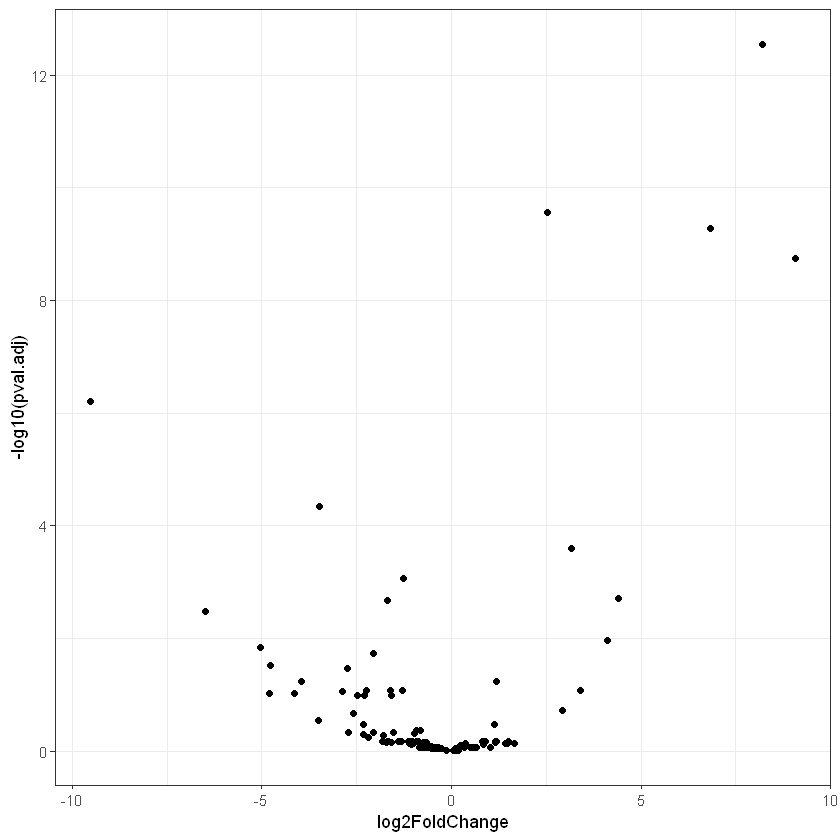

In [19]:
# Plotting package
library(ggplot2)

# Define plot
p <- ggplot(res_covar, aes(x = log2FoldChange, y = -log10(pval.adj))) +
    theme_bw() +
    geom_point()

# View plot
p

We can add a line to discrimate between significant and non-significant. And we can color by Phylum

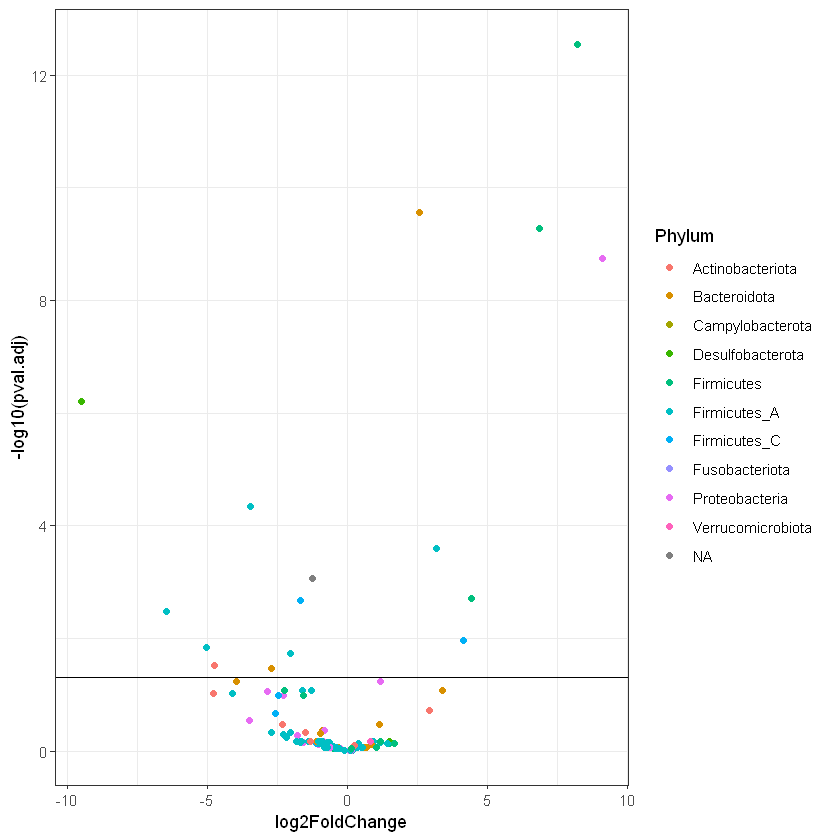

In [20]:
# Define plot
p <- ggplot(res_covar, aes(x = log2FoldChange, y = -log10(pval.adj), color = Phylum)) +
    theme_bw() +
    geom_point() +
    geom_hline(yintercept = -log10(0.05))

# View plot
p

Annotate the significant ones:

Warning message:
"Removed 1 rows containing missing values (geom_text_repel)."


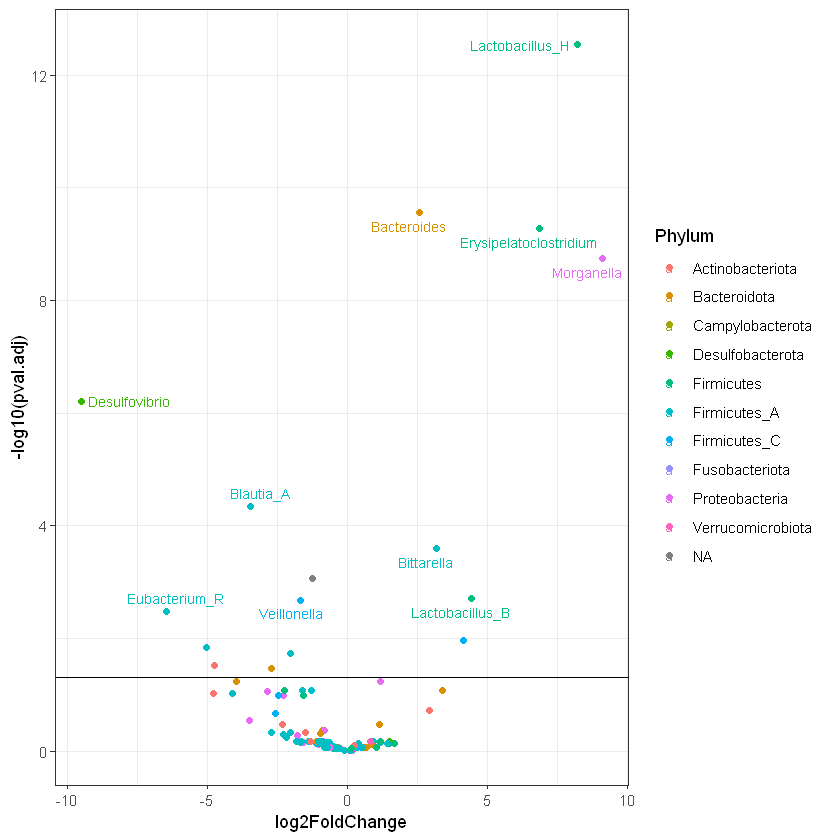

In [21]:
# Annotation package (install first time)
# install.packages("ggrepel")
library(ggrepel)

# Subset only highly significant
res_covar_sig <- res_covar[res_covar$pval.adj <= 0.01, ]

# Define plot
p <- ggplot(res_covar, aes(x = log2FoldChange, y = -log10(pval.adj), color = Phylum)) +
    theme_bw() +
    geom_point() +
    geom_hline(yintercept = -log10(0.05)) +
    geom_text_repel(data = res_covar_sig,
                    aes(x = log2FoldChange, y = -log10(pval.adj), label = Genus),
                    size = 3)

# View plot
p